In [5]:
import pandas as pd
import re
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [8]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Avaliable CPU cores: {num_processors}')

Avaliable CPU cores: 8


In [9]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 7 workers


In [10]:
%%time

df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: user 6.54 s, sys: 3.75 s, total: 10.3 s
Wall time: 26.6 s


(199677, 5)

In [11]:
def clean_text_data(text):
    # Remove tabs and carriage returns
    text = re.sub(r'(?:\t|\r)', '', text)
    # Replace newline characters with a space
    text = re.sub(r'(?:\n)', ' ', text)
    # Remove URLs that start with 'http', 'https', 'www' or contain '@'
    text = re.sub(r'(?:\@|http?\://|https?\://|www)\S+', '', text)
    # Remove special characters
    text = re.sub(r'(?:\xa0|\xad|\'|\\)', '', text)
    # Remove anything that's not a letter, number, some punctuation, or space
    # Keeps alphanumeric characters, basic punctuation, and newlines
    text = re.sub(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", text)
    # Remove backslashes
    text = re.sub(r"\\", " ", text)
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)  
    # Remove single quotes
    text = re.sub(r"\'", "", text)
    # Remove leading white spaces
    text = text.lstrip()

    return text

In [12]:
# Apply the cleaning function in parallel
df_news_final_project['cleaned_text'] = df_news_final_project['text'].apply(clean_text_data)

In [13]:
# remove irrelevant endings of the text
def remove_endings(text, ending_words):
    for ending_word in ending_words:
        idx = text.find(ending_word)
        if idx != -1:
            return text[:idx]
    return text

In [14]:
endings =  ['READ MORE：','View original content','Related Content','Read More','Related Stories',
            'Share This To World','Read more','Share this article','Related topics',
            'Related posts','Related News','Media Conact','For more information','View More','ExploreMore',
            'For More Information','Join Us','More information is available','Media Contact','Follow Us',
            'The views, opinions and statements in the press release','Next Article','More Stories',
            'This release was drafted by','About Us:','Trending:','Previous post:','Most Popular',
            'Related:','RELATED ARTICLES','Article Topic Follows','Subscriber Exclusives','Also read', 
            'Sponsored Content:','Author Bio','For Further Reading','Copyright Information', 'Connect with Us',
            'Further Details:','Follow on Social Media','Sign Up for Our Newsletter','Subscribe Now']

In [15]:
df_news_final_project['cleaned_text_noEND'] = df_news_final_project['cleaned_text'].apply(lambda x: remove_endings(x, endings))

In [16]:
# split the text into sentences by punctuation
df_news_final_project['cleaned_text_split'] = df_news_final_project['cleaned_text_noEND'].str.split('[.!?;,]')

In [17]:
# Define a function to further clean and process text data
def process_text_data(df, column_name, max_length=400):
    # Filter out items longer than max_length
    df[column_name + '_filtered'] = df[column_name].apply(lambda x: [item for item in x if len(item) < max_length])

    # Identify and store items that were removed
    df[column_name + '_removed'] = df[column_name].apply(lambda x: [item for item in x if len(item) >= max_length])

    # Concatenate the filtered items into a single string
    df[column_name + '_concatenated'] = df[column_name + '_filtered'].apply(lambda x: ' '.join(x).strip())

    # Replace multiple spaces with a single space
    df[column_name + '_concatenated'] = df[column_name + '_concatenated'].str.replace(' +', ' ', regex=True)

    return df

df_news_final_project = process_text_data(df_news_final_project, 'cleaned_text_split')


In [42]:
keywords = ['data science','Data Science','machine learning','Machine Learning','artificial intelligence',
            'Artificial Intelligence']

In [43]:
# only remain the ones with keywords
pattern = '|'.join(keywords)
df_news_final_project_filtered = df_news_final_project[df_news_final_project['cleaned_text_split_concatenated'].str.contains(pattern, case=False, na=False)]

In [44]:
df_news_final_project_filtered.shape

(120452, 11)

In [48]:
%%time

from textblob import TextBlob
#computes the polarity score of the text 
#Polarity is a float within the range [-1.0, 1.0], where -1.0 is very negative, 1.0 is very positive, and 0.0 is neutral.
df_news_final_project_filtered['polarity'] = df_news_final_project_filtered['cleaned_text_split_concatenated'].apply(lambda x: TextBlob(x).sentiment.polarity)
#Subjectivity is a float within the range [0.0, 1.0], where 0.0 is very objective and 1.0 is very subjective. The subjectivity score indicates whether the text expresses personal opinions, emotions, or judgments
df_news_final_project_filtered['subjectivity'] = df_news_final_project_filtered['cleaned_text_split_concatenated'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 11min 46s, sys: 115 ms, total: 11min 46s
Wall time: 11min 46s


<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
df_news_final_project_filtered.shape

(120452, 13)

In [27]:
from transformers import pipeline

# Load the sentiment analysis pipeline with the custom model
classifier = pipeline("sentiment-analysis", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [39]:
from tqdm import tqdm  # Import the tqdm class

In [50]:
%%time
# Function to split text into smaller segments
def split_text(text, max_length):
    split_texts = []
    start = 0
    while start < len(text):
        end = start + max_length
        split_texts.append(text[start:end])
        start = end
    return split_texts

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 16 µs


In [51]:
def batch_classify(texts, batch_size=16):
    results = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        labels = classifier(batch)
        results.extend([label['label'] for label in labels])
    return results

In [52]:
%%time
# Prepare your data as a list of texts
texts = df_news_final_project_filtered['cleaned_text_split_concatenated'].tolist()

CPU times: user 4.94 ms, sys: 3 µs, total: 4.94 ms
Wall time: 4.79 ms


In [53]:
%%time
# Split the texts into segments of max_length=512
segmented_texts = [segment for text in texts for segment in split_text(text, max_length=512)]

CPU times: user 384 ms, sys: 12 ms, total: 396 ms
Wall time: 394 ms


In [ ]:
from tqdm import tqdm  # Import the tqdm class
# Apply sentiment analysis in batches
sentiments = batch_classify(segmented_texts, batch_size=16)

100%|██████████| 74048/74048 [13:08:29<00:00,  1.57it/s]  


In [57]:
# Initialize a variable to keep track of the starting point of segments for each text
start_index = 0

# Create an empty list to store the grouped sentiments
grouped_sentiments = []

# Loop over each text in the original DataFrame
for text in df_news_final_project_filtered['cleaned_text_split_concatenated']:
    # Determine the number of segments this text was split into
    num_segments = len(split_text(text, max_length=512))
    
    # Extract the sentiments for these segments
    text_sentiments = sentiments[start_index:start_index + num_segments]
    
    # Append the grouped sentiments to the list
    grouped_sentiments.append(text_sentiments)
    
    # Update the start_index for the next text
    start_index += num_segments

# Now, assign this list of grouped sentiments back to the DataFrame
df_news_final_project_filtered['sentiments'] = grouped_sentiments


/var/tmp/ipykernel_2560/978252189.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_final_project_filtered['sentiments'] = grouped_sentiments


In [58]:
df_news_final_project_filtered.head(5)

url  \
0                                                            http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/   
2                                                                                                                                                        http://usweekly.com/news/17/40964/Artificial-intelligence-yields-new-antibiotic.html   
4                                                                                                                                      http://www.huewire.com/how-you-should-validate-machine-learning-models-by-patryk-miziula-phd-jul-2023/   
6                           http://www.sbwire.com/press-releases/machine-learning-data-catalog-software-market-2020-industry-trends-growth-insight-market-share-competitive-outlook-regional-and-global-industry-forecast-to-2028-1280539.htm   
8  https://3wnews.org/uncategorised/1351502/artificial-intelligence-in-behavioral-and-mental-health-care-market-to-witness-astonishing-growth-by-2026-focusing-on-leading-players-advancedmd-cerner-core-solutions-credible-behavioral-healt/   

         date language  \
0  2020-02-26       en   
2  2020-02-23       en   
4  2023-07-21       en   
6  2020-03-18       en   
8  2020-06-14       en   

                                                                                                                                                                                                                                title  \
0                                                                       LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis   
2                                                                                                                                                                            Artificial intelligence yields new antibiotic - USweekly   
4                                                                                          How You Should Validate Machine Learning Models | by Patryk Miziuła, PhD | Jul, 2023 | | #1 NEWS SOURCE FOR PEOPLE OF COLOR ON EARTH !!!!!   
6                                                                                                                                 Machine Learning Data Catalog Software Market 2020: Insights, Key Strategies, Innovative Trends and   
8  Artificial Intelligence In Behavioral And Mental Health Care Market to Witness Astonishing Growth by 2026 Focusing on Leading Players – AdvancedMD , Cerner , Core Solutions , Credible Behavioral Health – 3w Market News Reports   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [61]:
# aggregate or summarize the sentiments in each row 
df_news_final_project_filtered['aggregate_sentiment'] = df_news_final_project_filtered['sentiments'].apply(lambda x: Counter(x).most_common(1)[0][0])

/var/tmp/ipykernel_2560/2131447550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_final_project_filtered['aggregate_sentiment'] = df_news_final_project_filtered['sentiments'].apply(lambda x: Counter(x).most_common(1)[0][0])


In [60]:
from collections import Counter

In [62]:
df_news_final_project_filtered.head(5)

url  \
0                                                            http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/   
2                                                                                                                                                        http://usweekly.com/news/17/40964/Artificial-intelligence-yields-new-antibiotic.html   
4                                                                                                                                      http://www.huewire.com/how-you-should-validate-machine-learning-models-by-patryk-miziula-phd-jul-2023/   
6                           http://www.sbwire.com/press-releases/machine-learning-data-catalog-software-market-2020-industry-trends-growth-insight-market-share-competitive-outlook-regional-and-global-industry-forecast-to-2028-1280539.htm   
8  https://3wnews.org/uncategorised/1351502/artificial-intelligence-in-behavioral-and-mental-health-care-market-to-witness-astonishing-growth-by-2026-focusing-on-leading-players-advancedmd-cerner-core-solutions-credible-behavioral-healt/   

         date language  \
0  2020-02-26       en   
2  2020-02-23       en   
4  2023-07-21       en   
6  2020-03-18       en   
8  2020-06-14       en   

                                                                                                                                                                                                                                title  \
0                                                                       LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis   
2                                                                                                                                                                            Artificial intelligence yields new antibiotic - USweekly   
4                                                                                          How You Should Validate Machine Learning Models | by Patryk Miziuła, PhD | Jul, 2023 | | #1 NEWS SOURCE FOR PEOPLE OF COLOR ON EARTH !!!!!   
6                                                                                                                                 Machine Learning Data Catalog Software Market 2020: Insights, Key Strategies, Innovative Trends and   
8  Artificial Intelligence In Behavioral And Mental Health Care Market to Witness Astonishing Growth by 2026 Focusing on Leading Players – AdvancedMD , Cerner , Core Solutions , Credible Behavioral Health – 3w Market News Reports   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Text(0.5, 1.0, 'Polarity Distribution')

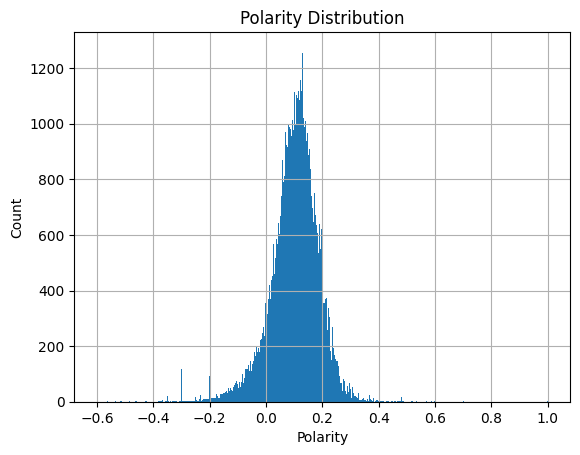

In [63]:
# plot the polarity distribution for better visualization
df_news_final_project_filtered['polarity'].hist(bins=1000)

plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Polarity Distribution')

In [64]:
# show the quantiles of polarity
df_news_final_project_filtered['polarity'].quantile([0.1,0.25, 0.5, 0.7,0.9])

0.10   -0.004167
0.25    0.055564
0.50    0.106566
0.70    0.142898
0.90    0.198958
Name: polarity, dtype: float64

Text(0.5, 1.0, 'Subjectivity Distribution')

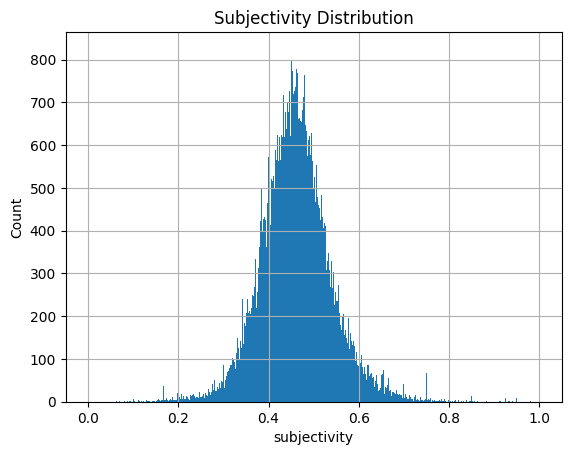

In [65]:
# plot the subjectivity distribution for better visualization
df_news_final_project_filtered['subjectivity'].hist(bins=1000)

plt.xlabel('subjectivity')
plt.ylabel('Count')
plt.title('Subjectivity Distribution')

In [66]:
# show the quantiles of subjectivity
df_news_final_project_filtered['subjectivity'].quantile([0.1,0.25, 0.5, 0.7,0.9])

0.10    0.367454
0.25    0.412453
0.50    0.458726
0.70    0.494905
0.90    0.556792
Name: subjectivity, dtype: float64

In [67]:
# show 3 random rows to mannually check
df_news_final_project_filtered[['aggregate_sentiment', 'polarity', 'subjectivity', 'cleaned_text_split_concatenated']].sample(n=3)

aggregate_sentiment  polarity  subjectivity  \
152163             neutral  0.172662      0.464613   
144446            negative  0.064120      0.462269   
46917              neutral  0.111532      0.462514   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [70]:
# mannually check
#df_news_final_project_filtered.head(75)

In [69]:
# count aggregate_sentiment numbers
df_news_final_project_filtered['aggregate_sentiment'].value_counts()

aggregate_sentiment
neutral     83210
positive    34668
negative     2574
Name: count, dtype: int64

In [84]:
#extract positive sentiments
pos_sentiment = df_news_final_project_filtered[df_news_final_project_filtered['aggregate_sentiment'] == 'positive']

In [82]:
#df_news_final_project_filtered.head(1)

In [85]:
#extract negative sentiments
neg_sentiment = df_news_final_project_filtered[df_news_final_project_filtered['aggregate_sentiment'] == 'negative']

K-train for sentiment analysis on topics

In [86]:
# for positive
texts = pos_sentiment['cleaned_text_split_concatenated'].tolist()

In [88]:
#pos_sentiment.head(2)

In [89]:
#!pip install ktrain
import ktrain

In [90]:
%%time
tm = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=8, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 2min 30s, sys: 27.6 s, total: 2min 58s
Wall time: 2min 11s


In [91]:
%%time
tm.print_topics()

topic 0 | year stock news billion stocks microsoft companies tech market investors
topic 1 | health care healthcare medical patients clinical patient cancer platform imaging
topic 2 | research science world work university people india students education says
topic 3 | generative security cloud organizations platform models capabilities management risk machine
topic 4 | market growth global report industry analysis research forecast key demand
topic 5 | edge energy performance solutions power computing nvidia applications high systems
topic 6 | solutions platform global prnewswire services digital companies leading customers cloud
topic 7 | customer content experience users chatgpt customers product service language generative
CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 9.94 ms


In [92]:
%%time
tm.build(texts, threshold=0.25)

done.
CPU times: user 37.4 s, sys: 4.48 s, total: 41.9 s
Wall time: 34.2 s


In [93]:
%%time
tm.print_topics(show_counts=True)

topic:6 | count:6371 | solutions platform global prnewswire services digital companies leading customers cloud
topic:0 | count:5230 | year stock news billion stocks microsoft companies tech market investors
topic:7 | count:4751 | customer content experience users chatgpt customers product service language generative
topic:3 | count:4334 | generative security cloud organizations platform models capabilities management risk machine
topic:1 | count:4245 | health care healthcare medical patients clinical patient cancer platform imaging
topic:2 | count:4242 | research science world work university people india students education says
topic:5 | count:3418 | edge energy performance solutions power computing nvidia applications high systems
topic:4 | count:1842 | market growth global report industry analysis research forecast key demand
CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 9.98 ms


In [95]:
%%time
# for negative
texts = neg_sentiment['cleaned_text_split_concatenated'].tolist()

CPU times: user 709 µs, sys: 0 ns, total: 709 µs
Wall time: 722 µs


In [96]:
%%time
tm = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=8, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 7.8 s, sys: 12 ms, total: 7.81 s
Wall time: 7.8 s


In [97]:
%%time
tm.print_topics()

topic 0 | china weapons summit warns think risks government global countries christian
topic 1 | year says china market company stocks billion stock bank video
topic 2 | data business tech systems companies world report use people global
topic 3 | chatgpt google openai company microsoft search chatbot twitter users like
topic 4 | americans believe jobs adults survey tasks say good prnewswire job
topic 5 | health aug healthcare study comments covid medical tweets french english
topic 6 | learning machine shares market price share trading traded volume stock
topic 7 | insurance consumer watchdog companies actors use algorithms hollywood writers drivers
CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 9.78 ms


In [98]:
%%time
tm.build(texts, threshold=0.25)

done.
CPU times: user 1.78 s, sys: 12 µs, total: 1.78 s
Wall time: 1.78 s


In [99]:
%%time
tm.print_topics(show_counts=True)

topic:3 | count:897 | chatgpt google openai company microsoft search chatbot twitter users like
topic:2 | count:655 | data business tech systems companies world report use people global
topic:1 | count:474 | year says china market company stocks billion stock bank video
topic:6 | count:350 | learning machine shares market price share trading traded volume stock
topic:5 | count:76 | health aug healthcare study comments covid medical tweets french english
topic:7 | count:53 | insurance consumer watchdog companies actors use algorithms hollywood writers drivers
topic:0 | count:36 | china weapons summit warns think risks government global countries christian
topic:4 | count:32 | americans believe jobs adults survey tasks say good prnewswire job
CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 10.1 ms


sentiment analysis over time

CPU times: user 137 ms, sys: 12 ms, total: 149 ms
Wall time: 109 ms


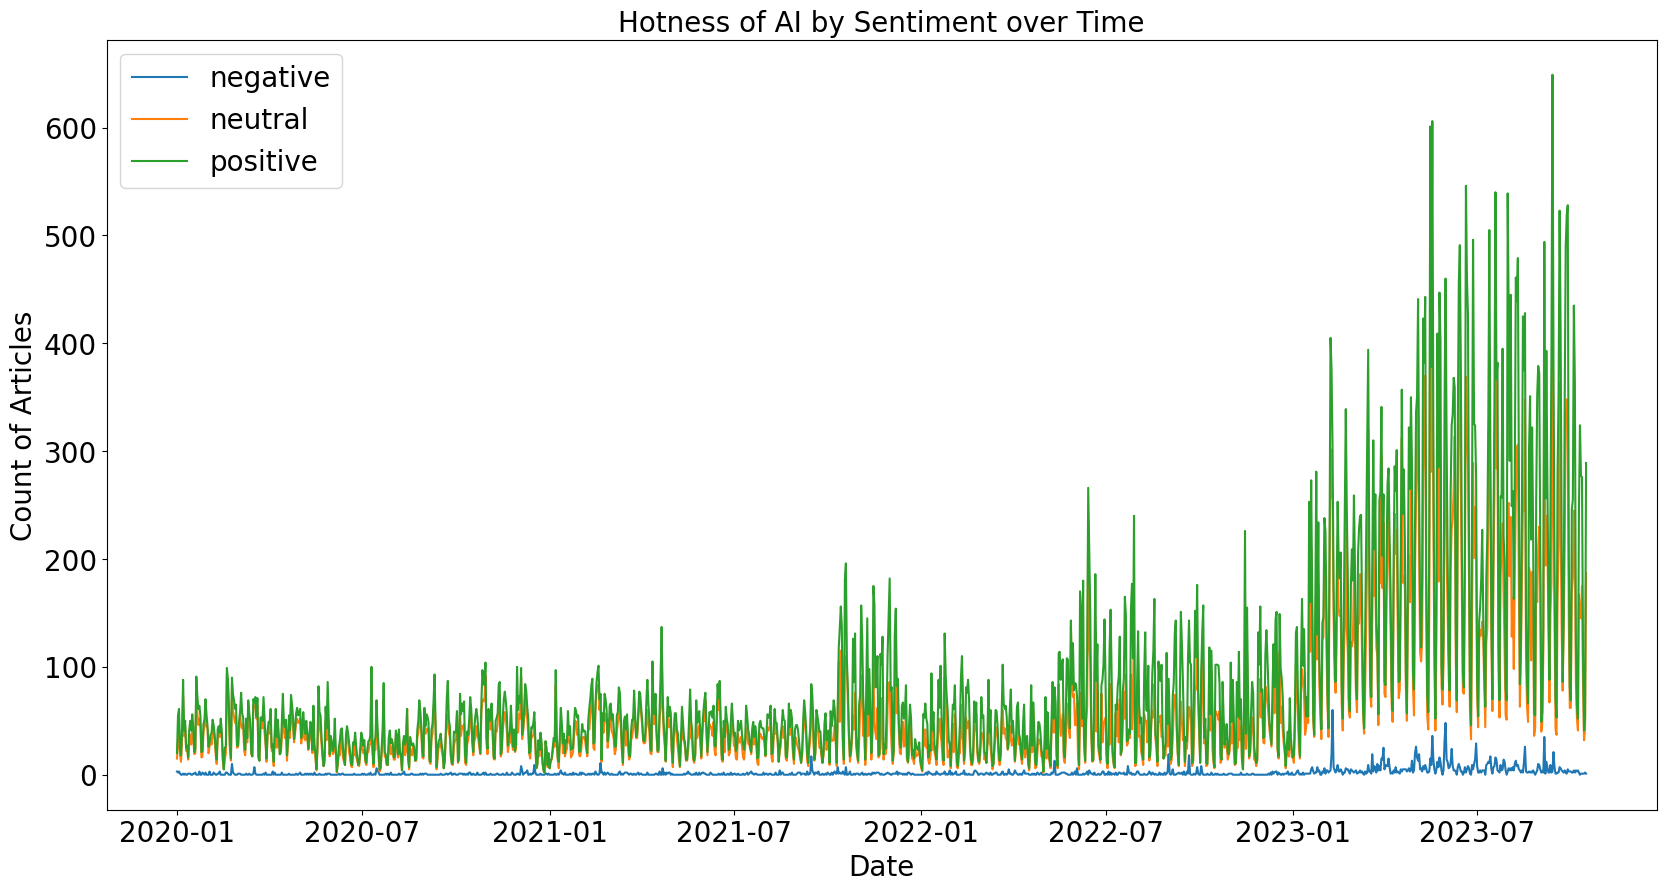

In [100]:
%%time

# plot the count of sentiment_agg by date and by Negative and Positive over date
df_news_final_project_filtered.groupby(['date', 'aggregate_sentiment']).size().unstack().plot(kind='line', stacked=True, figsize=(20,10))
plt.title('Hotness of AI by Sentiment over Time', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Count of Articles', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

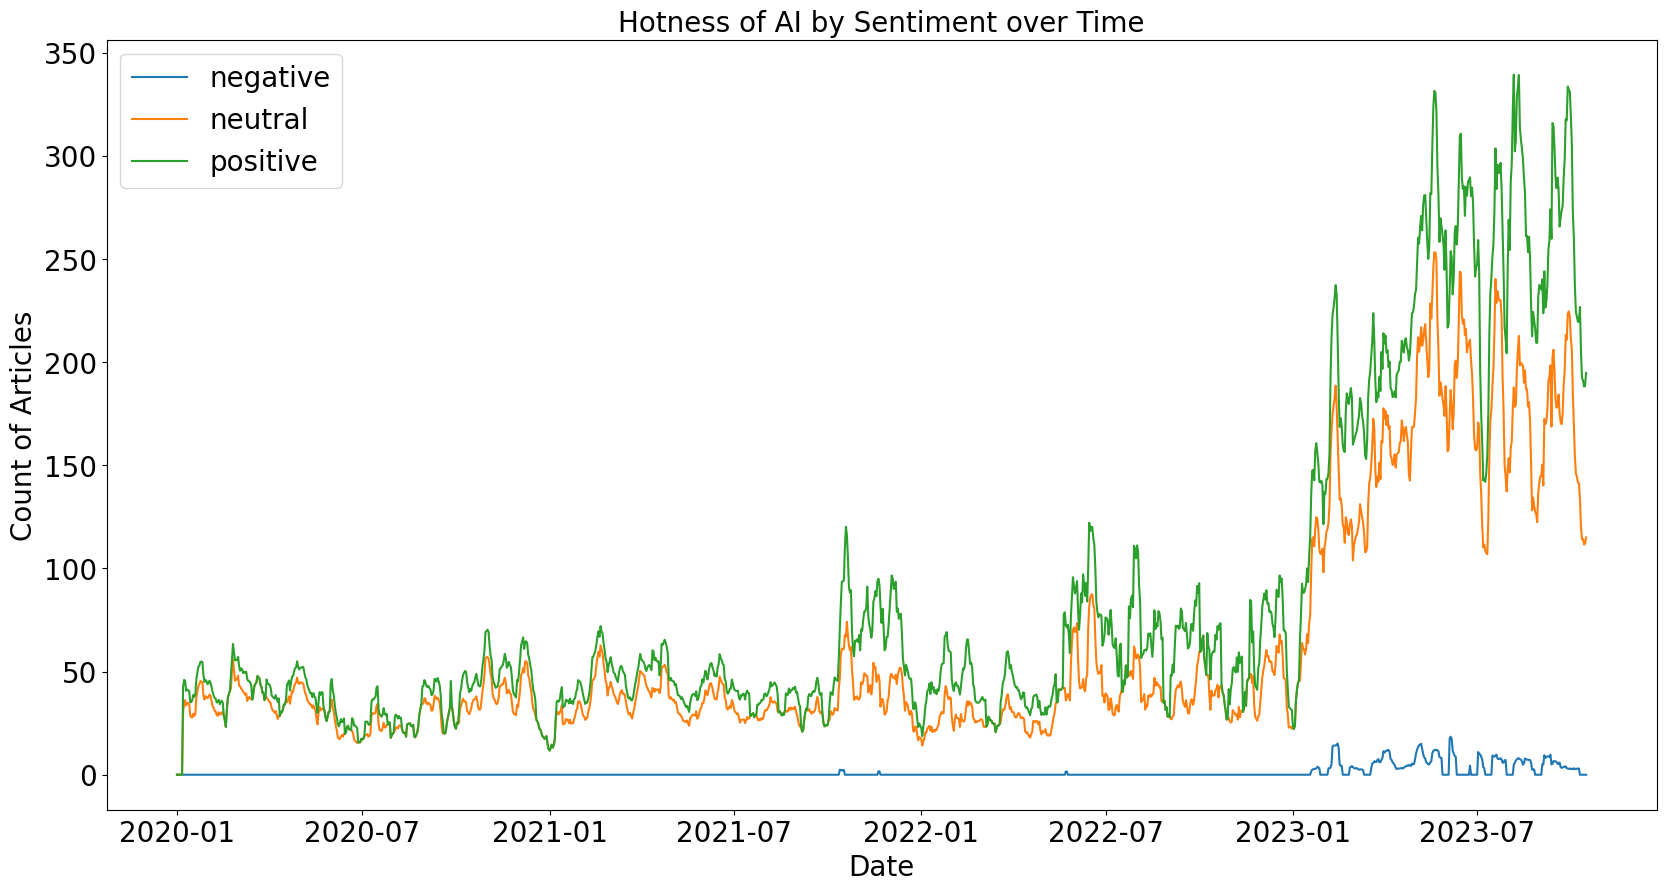

In [101]:
# for more readable visualization
df_news_final_project_filtered.groupby(['date', 'aggregate_sentiment']).size().unstack().rolling(7).mean().plot(kind='line', stacked=True, figsize=(20,10))
plt.title('Hotness of AI by Sentiment over Time', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Count of Articles', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

NER

In [105]:
#!python -m spacy download en_core_web_sm

In [ ]:
%%time
# apply Spacy NER with label PERSON, ORG, GPE, PRODUCT...
nlp = spacy.load("en_core_web_sm")

# define the function to get the entities
def get_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df_news_final_project_filtered['entities'] = df_news_final_project_filtered['cleaned_text_split_concatenated'].apply(get_entities)

CPU times: user 2h 57min 40s, sys: 2.53 s, total: 2h 57min 43s
Wall time: 2h 57min 43s


<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [107]:
technology_names = [
    "SmartBrain","NeuroSense","GeneticAI","DataWhiz","TechVision","AI Assist",
    "NeuroLogic","RoboVision","CogniSys","SmartAI","IntelliBot","SentiTech",
    "DeepSense","IntelliVision","SmartSense","DeepMind","CogniTech","NeuroBot",
    "AI Analyzer","SentiSense","RoboGenius","CognitiveHub","SynthAI",
    "IntelliNet","MindLink","Bixby", "DuerOS", "Xiaoice", "Alibaba", 
    "Tmall Genie", "AliGenie", "AliMe", "Ali Xiaomi", "Xiaomi","Stability Ai",
    "Deepbrain Chain", "SingularityNET","Neuromation", "Matrix AI Network", 
    "NeuroChain", "Neurotoken", "Neuromation", "Neurogress","Deepbrain AI", 
    "GPT-4", "GPT-3", "GPT-2", "GPT-1", "Quantum AI", "Quantum Computing", 
    "Quantum Machine Learning", "Quantum Deep Learning", "Quantum Neural Network",
    "Quantum Computing", "Quantum Machine Learning", "CognitiveGen","NeuroLink",
    "AI Master","DataMind","TechGenius","IntelliSense","Chatbot","ChatGPT",
    "ChatAI","ChatSense","ImageAI","ImageSense","ImageVision","ImageGenius",
    "ImageBot","ImageMaster","ImageNet","ImageWhiz","ImageLogic","ImageLink",
    "ImageGen","ImageTech","VoiceAI","VoiceSense","VoiceVision","VoiceGenius",
    "VoiceBot","VoiceMaster","VoiceNet","VoiceWhiz","VoiceLogic","VoiceLink",
    "VoiceGen","VoiceTech","Siri", "Alexa", "Google Assistant", "Cortana",
    "Quantum Deep Learning", "Quantum Neural Network", "Quantum AI", "Quantum AI",
    "Quantum AI", "Quantum AI","Natural language generation", 
    "Speech recognition", "Virtual agents", "Machine learning platforms", 
    "AI-optimized hardware", "Decision management","vitual assistant",
    "virtual agent", "Decision Management", "Biometrics", 
    "Robotic process automation", "Peer-to-peer network", 
    "Deep Learning Platforms","AL-optimized hardware", "Decision Management", 
    "Biometrics", "Robotic process automation", "Peer-to-peer network", 
    "Deep Learning Platforms"
]

# remove duplicates
technology_names = list(set(technology_names))

In [108]:
len(technology_names)

104

In [109]:
# remove names that are not in the positive text
technology_names = [name for name in technology_names if name.lower() in ' '.join(pos_sentiment['text']).lower()]

len(technology_names)

57

In [110]:
# get the count for each technology name
technology_names_count = [pos_sentiment['text'].str.count(name).sum() for name in technology_names]

# create a dataframe

df_technology_names = pd.DataFrame({'technology_names': technology_names, 'technology_names_count': technology_names_count})

# sort the dataframe by technology_names_count
df_technology_names = df_technology_names.sort_values(by='technology_names_count', ascending=False)

# romove rows with technology_names_count = 0
df_technology_names = df_technology_names[df_technology_names['technology_names_count'] > 0]

len(df_technology_names)

46

<Axes: xlabel='technology_names'>

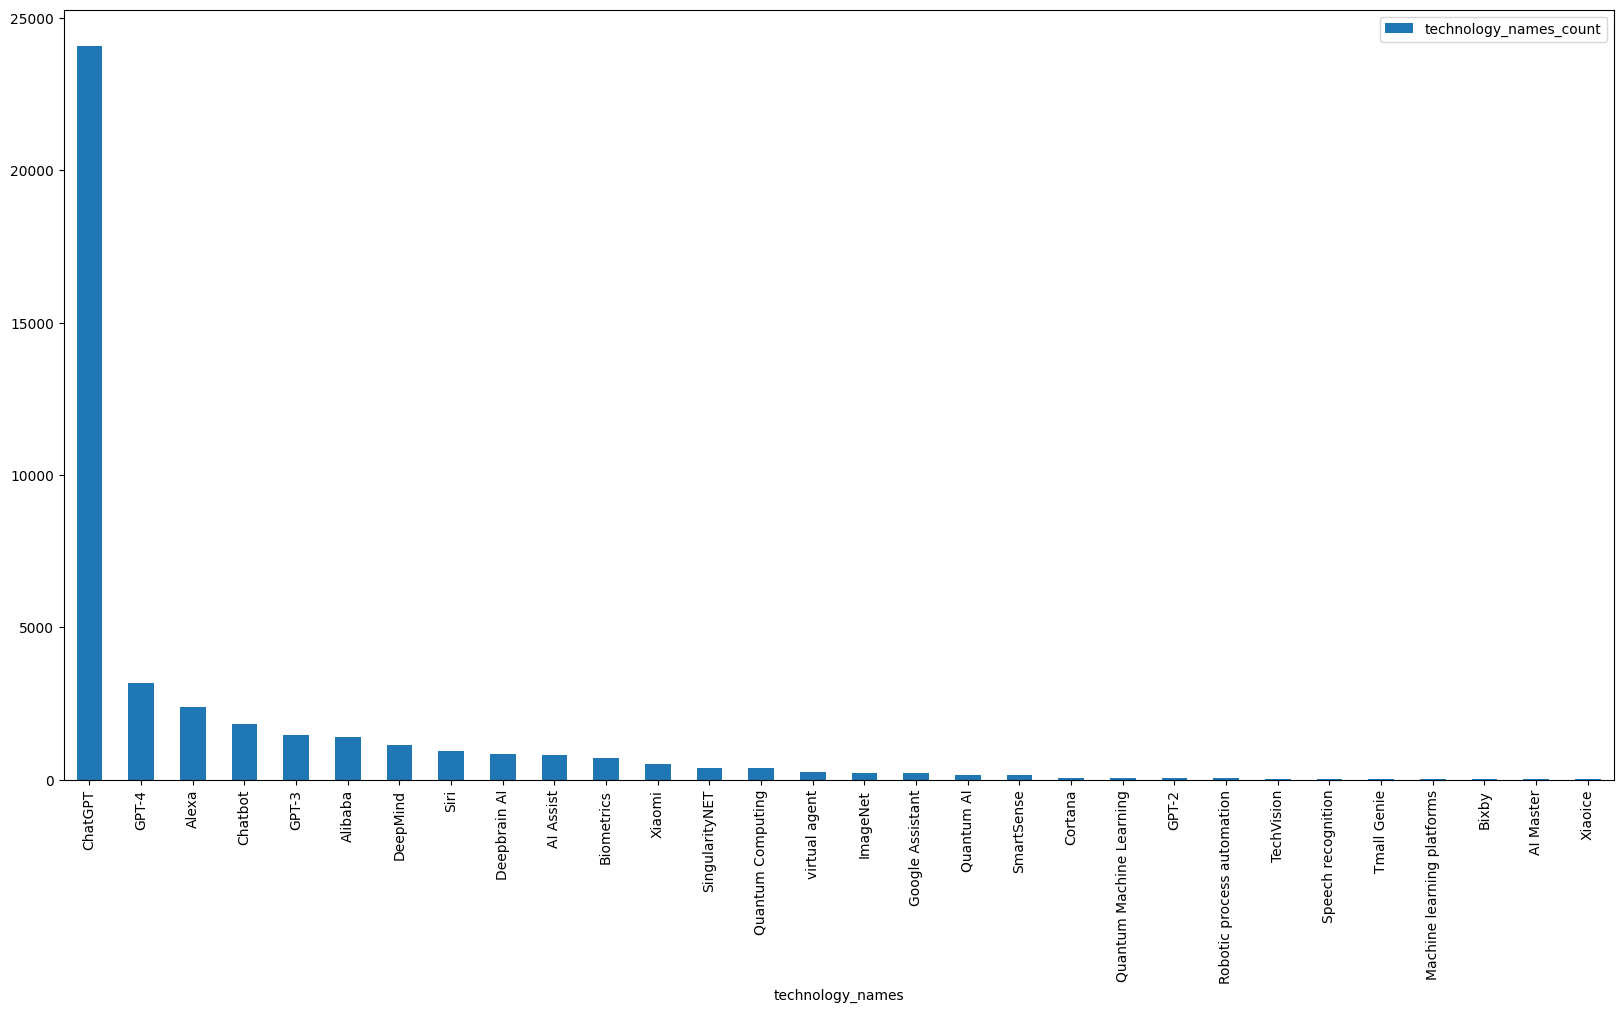

In [111]:
# plot the top 30 technology names

df_technology_names.head(30).plot.bar(x='technology_names', y='technology_names_count', figsize=(20,10))

In [121]:
# Create a dataframe to store the timeline for each technology name
df_technology_names_timeline = pd.DataFrame(columns=['technology_names', 'timeline'])

# loop through each technology name
for name in df_technology_names['technology_names']:
    # get the timeline for each technology name
    filtered = pos_sentiment[pos_sentiment['text'].str.contains(name, na=False)]
    earliest_date = filtered['date'].min()

    # Convert new_row to a DataFrame before appending
    new_row_df = pd.DataFrame({'technology_names': [name], 'timeline': [earliest_date]})
    df_technology_names_timeline = pd.concat([df_technology_names_timeline, new_row_df], ignore_index=True)

df_technology_names_timeline


,technology_names,timeline
0,ChatGPT,2022-12-03
1,GPT-4,2023-01-05
2,Alexa,2020-01-06
3,Chatbot,2020-01-02
4,GPT-3,2020-05-29
5,Alibaba,2020-01-03
6,DeepMind,2020-01-01
7,Siri,2020-01-02
8,Deepbrain AI,2021-10-07
9,AI Assist,2020-07-17


In [119]:
pd.__version__

'2.0.3'

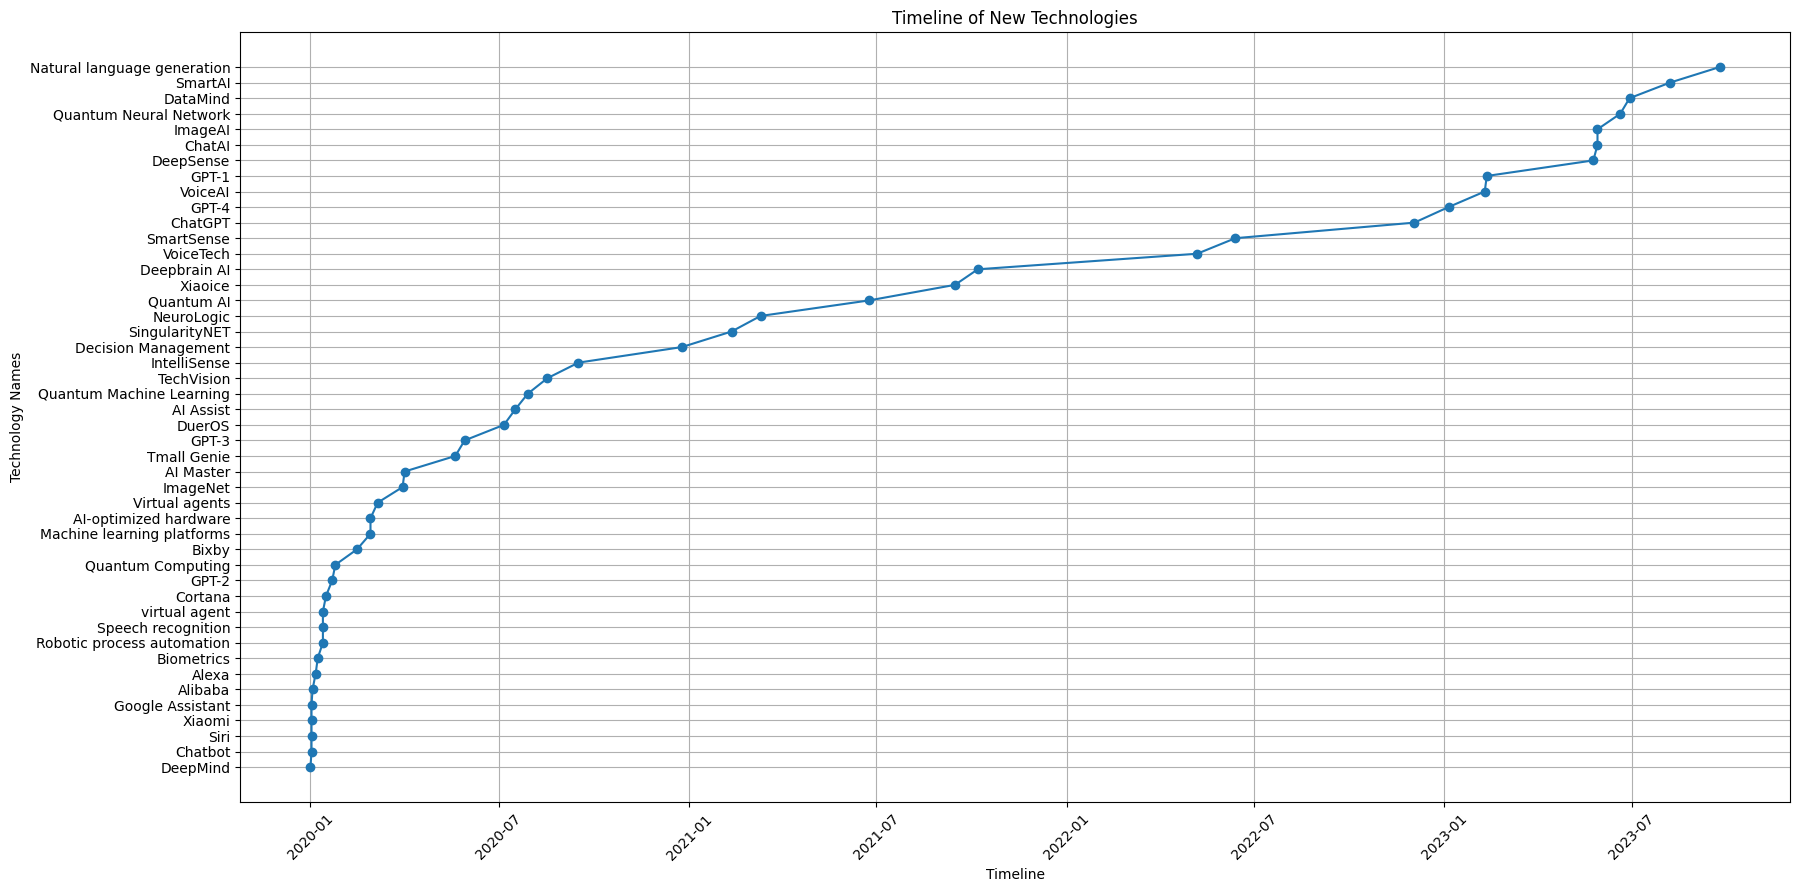

In [122]:
# Convert timeline to datetime format
df_technology_names_timeline['timeline'] = pd.to_datetime(df_technology_names_timeline['timeline'])

# Sort the DataFrame by timeline
df = df_technology_names_timeline.sort_values(by='timeline')

# Plotting the timeline
plt.figure(figsize=(20, 10))
plt.plot(df['timeline'], df['technology_names'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Timeline')
plt.ylabel('Technology Names')
plt.title('Timeline of New Technologies')
plt.grid(True)

People

In [135]:
entity_types = set()
for sublist in df_news_final_project_filtered['entities']:
    for pair in sublist:
        entity_type = pair[1]
        entity_types.add(entity_type)

print(entity_types)

{'PERCENT', 'ORG', 'DATE', 'MONEY', 'LANGUAGE', 'NORP', 'ORDINAL', 'PERSON', 'PRODUCT', 'CARDINAL', 'EVENT', 'LOC', 'WORK_OF_ART', 'LAW', 'QUANTITY', 'FAC', 'TIME', 'GPE'}


In [136]:
# keep PERSON
df_news_final_project_filtered['entities_per'] = df_news_final_project_filtered['entities'].apply(lambda x: [pair for pair in x if pair[1] in ['PERSON']])

entity_types = set()
for sublist in df_news_final_project_filtered['entities_per']:
    for pair in sublist:
        entity_type = pair[1]
        entity_types.add(entity_type)

print(entity_types)

/var/tmp/ipykernel_2560/2222341452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_final_project_filtered['entities_per'] = df_news_final_project_filtered['entities'].apply(lambda x: [pair for pair in x if pair[1] in ['PERSON']])


{'PERSON'}


In [137]:
# get top entities for person
df_news_final_project_filtered['entities_per'] = df_news_final_project_filtered['entities_per'].apply(lambda x: [pair[0] for pair in x])

# calculate the count for each entity
entity_count = Counter([entity for sublist in df_news_final_project_filtered['entities_per'] for entity in sublist])
df_entity_count = pd.DataFrame({'entities_per': entity_count.keys(), 'count': entity_count.values()})

# sort by count
df_entity_count = df_entity_count.sort_values(by='count', ascending=False)

/var/tmp/ipykernel_2560/3714269121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_final_project_filtered['entities_per'] = df_news_final_project_filtered['entities_per'].apply(lambda x: [pair[0] for pair in x])


In [139]:
# see top 100
df_entity_count.head(100)

,entities_per,count
1122,WhatsApp,5910
7,Biden,5566
65,Elon Musk,4807
453,Twitter,4728
67,Musk,4611
287,Sam Altman,4082
196,AI,3713
126,Generative AI,3620
20,Covid,3268
700,Forgot,2807


In [129]:
#!pip install wordcloud

In [130]:
from wordcloud import WordCloud


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


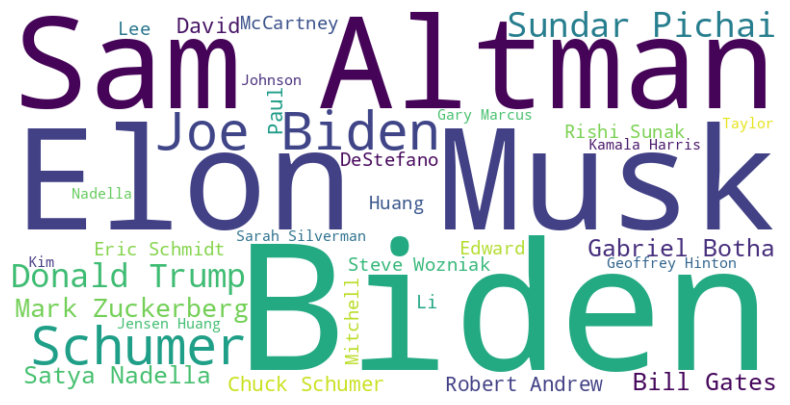

In [140]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Your data (you might have this in a DataFrame already)
data = {
    'entities_per': [
        'Elon Musk', 'Biden', 'Sam Altman', 'Joe Biden', 'Sundar Pichai', 
        'Donald Trump', 'Mark Zuckerberg', 'Schumer', 'Bill Gates', 'Gabriel Botha', 
        'Satya Nadella', 'David', 'Paul', 'Chuck Schumer', 'Robert Andrew', 
        'Rishi Sunak', 'Eric Schmidt', 'Edward', 'DeStefano', 'Huang', 
        'Steve Wozniak', 'Mitchell', 'McCartney', 'Li', 'Lee', 
        'Geoffrey Hinton', 'Gary Marcus', 'Jensen Huang', 'Nadella', 'Taylor', 
        'Kamala Harris', 'Kim', 'Johnson', 'Sarah Silverman'
    ],
    'count': [4807, 5566, 4082, 2297, 1667, 1546, 1463, 2241, 1233, 1187, 1242, 941, 893, 872, 859, 715, 705, 699, 699, 687, 654, 648, 637, 634, 617, 608, 603, 590, 582, 579, 568, 566, 558, 556] # example counts
}

# Create a frequency dictionary for word cloud
freq_dict = {name: count for name, count in zip(data['entities_per'], data['count'])}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


organization

In [142]:
# keep organization
df_news_final_project_filtered['entities_org'] = df_news_final_project_filtered['entities'].apply(lambda x: [pair for pair in x if pair[1] in ['ORG']])

entity_types = set()
for sublist in df_news_final_project_filtered['entities_org']:
    for pair in sublist:
        entity_type = pair[1]
        entity_types.add(entity_type)

print(entity_types)

/var/tmp/ipykernel_2560/1099013026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_final_project_filtered['entities_org'] = df_news_final_project_filtered['entities'].apply(lambda x: [pair for pair in x if pair[1] in ['ORG']])


{'ORG'}


In [143]:
# get top entities for organization
df_news_final_project_filtered['entities_org'] = df_news_final_project_filtered['entities_org'].apply(lambda x: [pair[0] for pair in x])

# calculate the count for each entity
entity_count = Counter([entity for sublist in df_news_final_project_filtered['entities_org'] for entity in sublist])
df_entity_count = pd.DataFrame({'entities_org': entity_count.keys(), 'count': entity_count.values()})

# sort by count
df_entity_count = df_entity_count.sort_values(by='count', ascending=False)

/var/tmp/ipykernel_2560/3484342047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news_final_project_filtered['entities_org'] = df_news_final_project_filtered['entities_org'].apply(lambda x: [pair[0] for pair in x])


In [145]:
# sort by count
df_entity_count = df_entity_count.sort_values(by='count', ascending=False)
df_entity_count.head(100)

,entities_org,count
113,AI,665649
149,Microsoft,43700
162,Google,43579
47,Artificial Intelligence,20720
218,ML,19203
86,Amazon,15258
36,IBM,13868
468,U S,12438
1316,AP,10756
81,EU,9020


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


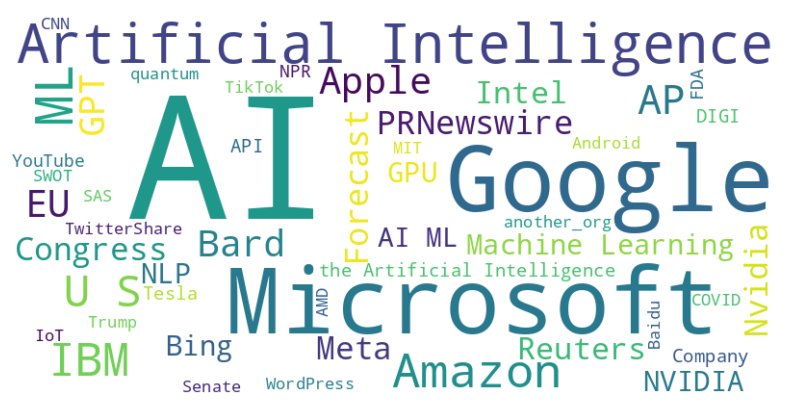

In [146]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
data = {
    'entities_org': ['AI', 'Microsoft', 'Google', 'Artificial Intelligence', 'ML', 'Amazon', 'IBM', 'U S', 'AP', 'EU', 
                     'Apple', 'Bard', 'GPT', 'Forecast', 'PRNewswire', 'Meta', 'Congress', 'Nvidia', 'Intel', 'Reuters',
                     'Machine Learning', 'GPU', 'NVIDIA', 'NLP', 'Bing', 'AI ML', 'the Artificial Intelligence', 'Company', 
                     'DIGI', 'Tesla', 'API', 'YouTube', 'FDA', 'NPR', 'Baidu', 'CNN', 'Android', 'SWOT', 'SAS', 'WordPress',
                     'COVID', 'quantum', 'Trump', 'IoT', 'MIT', 'Senate', 'TikTok', 'TwitterShare', 'AMD', 'another_org'],
    'count': [665649, 43700, 43579, 20720, 19203, 15258, 13868, 12438, 10756, 9020, 8980, 8296, 8042, 6552, 6393, 6136, 
              5957, 5928, 5619, 5534, 5116, 4941, 4916, 4844, 4787, 4608, 4562, 4393, 4251, 4197, 3988, 3654, 3570, 3565, 
              3363, 3362, 3346, 3236, 3166, 3139, 3097, 2938, 2824, 2797, 2726, 2719, 2674, 2670, 2655, 2551] # example counts
}

# Create a frequency dictionary for word cloud
freq_dict = {name: count for name, count in zip(data['entities_org'], data['count'])}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Targeted sentiment (positive)

In [147]:
pos_sentiment = df_news_final_project_filtered[df_news_final_project_filtered['aggregate_sentiment'] == 'positive']
neg_sentiment = df_news_final_project_filtered[df_news_final_project_filtered['aggregate_sentiment'] == 'negative']

In [148]:
entity_types = set()
for sublist in pos_sentiment['entities']:
    for pair in sublist:
        entity_type = pair[1]
        entity_types.add(entity_type)

print(entity_types)

{'PERCENT', 'ORG', 'DATE', 'MONEY', 'LANGUAGE', 'ORDINAL', 'PERSON', 'PRODUCT', 'CARDINAL', 'TIME', 'LOC', 'WORK_OF_ART', 'EVENT', 'QUANTITY', 'LAW', 'FAC', 'NORP', 'GPE'}


In [150]:
# keep ORG
pos_sentiment['entities'] = pos_sentiment['entities'].apply(lambda x: [pair for pair in x if pair[1] in ['ORG']])

entity_types = set()
for sublist in pos_sentiment['entities']:
    for pair in sublist:
        entity_type = pair[1]
        entity_types.add(entity_type)

print(entity_types)

/var/tmp/ipykernel_2560/3133020188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_sentiment['entities'] = pos_sentiment['entities'].apply(lambda x: [pair for pair in x if pair[1] in ['ORG']])


{'ORG'}


In [151]:
# get top 20 entities for 'ORG'
pos_sentiment['entities'] = pos_sentiment['entities'].apply(lambda x: [pair[0] for pair in x])

# get the count for each entity
entity_count = Counter([entity for sublist in pos_sentiment['entities'] for entity in sublist])

# create a dataframe
df_entity_count = pd.DataFrame({'entity': entity_count.keys(), 'count': entity_count.values()})

# sort the dataframe by count
df_entity_count = df_entity_count.sort_values(by='count', ascending=False)

/var/tmp/ipykernel_2560/1898644673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_sentiment['entities'] = pos_sentiment['entities'].apply(lambda x: [pair[0] for pair in x])


In [152]:
# sort by count
df_entity_count = df_entity_count.sort_values(by='count', ascending=False)
df_entity_count.head(100)

,entity,count
4,AI,214997
90,Microsoft,11943
375,ML,8725
105,Google,7050
476,Artificial Intelligence,4398
739,IBM,3995
47,Amazon,3985
827,PRNewswire,3440
53,U S,3320
44,Nvidia,3162


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


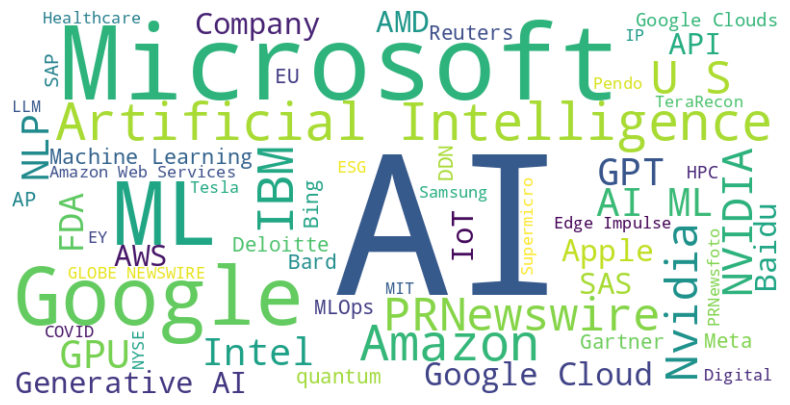

In [153]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample data - replace with your actual DataFrame
data = {
    'entity': ['AI', 'Microsoft', 'ML', 'Google', 'Artificial Intelligence', 'IBM', 'Amazon', 'PRNewswire', 'U S', 
               'Nvidia', 'NVIDIA', 'GPU', 'AI ML', 'GPT', 'Intel', 'NLP', 'FDA', 'Google Cloud', 'Apple', 'Baidu', 
               'AWS', 'API', 'SAS', 'Company', 'AMD', 'IoT', 'Generative AI', 'Machine Learning', 'Deloitte', 'quantum', 
               'Gartner', 'Bard', 'Meta', 'AP', 'DDN', 'MLOps', 'EU', 'Reuters', 'Bing', 'SAP', 'Google Clouds', 
               'HPC', 'Amazon Web Services', 'GLOBE NEWSWIRE', 'Edge Impulse', 'Digital', 'LLM', 'Supermicro', 
               'Pendo', 'Healthcare', 'ESG', 'COVID', 'NYSE', 'IP', 'EY', 'Tesla', 'TeraRecon', 'Samsung', 'MIT', 
               'PRNewsfoto', 'SEC', 'ICT', 'CPU', 'CTO', 'RPA', 'Roche', 'AI Studios', 'NVDA', 'Forecast', 'RSS', 
               'UAE', 'Groq', 'AML', 'Oracle', 'EV', 'YouTube', 'NHS', 'WEKA', 'Ginkgo', 'SourceCode', 'CT', 'KPMG', 
               'Data', 'Android', 'APAC', 'IPO', 'Botkeeper', 'Edge', 'Orbis', 'LLC', 'Chinas', 'Nasdaq Inc All Rights Reserved My Quotes My Quotes Watchlist Portfolio Add Edit Symbols View', 
               'Huawei', 'Thomson Reuters', 'FacebookShare', 'Fed', 'Artificial', 'EPS', 'The Motley Fool', 'CNBC'],
    'count': [214997, 11943, 8725, 7050, 4398, 3995, 3985, 3440, 3320, 3162, 2693, 2486, 2457, 2266, 2218, 2190, 1720, 
              1591, 1499, 1442, 1438, 1420, 1417, 1398, 1391, 1371, 1343, 1304, 1223, 1203, 1191, 1167, 1131, 1102, 
              1089, 1086, 1079, 1048, 1036, 975, 944, 846, 845, 840, 837, 836, 817, 770, 742, 739, 734, 730, 719, 
              718, 692, 682, 663, 658, 641, 634, 612, 611, 595, 591, 576, 575, 568, 561, 554, 547, 542, 542, 528, 527, 
              525, 520, 512, 485, 480, 473, 471, 470, 470, 466, 460, 459, 453, 453, 447, 444, 442, 426, 423, 418, 417, 
              409, 406, 404, 401, 400]
}

# Create DataFrame
df = pd.DataFrame(data)

# Selecting top 60 organizations
top_60_df = df.nlargest(60, 'count')

# Create a frequency dictionary for word cloud
freq_dict = {name: count for name, count in zip(top_60_df['entity'], top_60_df['count'])}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Targeted sentiment (negative)

In [154]:
entity_types = set()
for sublist in neg_sentiment['entities']:
    for pair in sublist:
        entity_type = pair[1]
        entity_types.add(entity_type)

print(entity_types)

{'PERCENT', 'ORG', 'DATE', 'MONEY', 'LANGUAGE', 'ORDINAL', 'PERSON', 'TIME', 'CARDINAL', 'EVENT', 'LOC', 'WORK_OF_ART', 'PRODUCT', 'LAW', 'QUANTITY', 'FAC', 'NORP', 'GPE'}


In [155]:
# keep only ORG
neg_sentiment['entities'] = neg_sentiment['entities'].apply(lambda x: [pair for pair in x if pair[1] in ['ORG']])

entity_types = set()
for sublist in neg_sentiment['entities']:
    for pair in sublist:
        entity_type = pair[1]
        entity_types.add(entity_type)

print(entity_types)

{'ORG'}


/var/tmp/ipykernel_2560/2139353342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_sentiment['entities'] = neg_sentiment['entities'].apply(lambda x: [pair for pair in x if pair[1] in ['ORG']])


In [156]:
# get top entities for 'ORG'
neg_sentiment['entities'] = neg_sentiment['entities'].apply(lambda x: [pair[0] for pair in x])

# get the count for each entity
entity_count = Counter([entity for sublist in neg_sentiment['entities'] for entity in sublist])

# create a dataframe
df_entity_count = pd.DataFrame({'entity': entity_count.keys(), 'count': entity_count.values()})

# sort the dataframe by count
df_entity_count = df_entity_count.sort_values(by='count', ascending=False)

/var/tmp/ipykernel_2560/3586710300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_sentiment['entities'] = neg_sentiment['entities'].apply(lambda x: [pair[0] for pair in x])


In [157]:
# sort by count
df_entity_count = df_entity_count.sort_values(by='count', ascending=False)
df_entity_count.head(100)

,entity,count
3,AI,10519
115,Google,1857
123,Microsoft,1177
214,U S,612
121,Bard,513
15,EU,390
236,Lisk Machine Learning,352
206,Apple,336
503,Nvidia,303
305,Reuters,279


In [158]:
# combine Gray Television Inc,Gray Media Group,Gray Media Group Inc Station, and Gray Media Group Inc to Gray Media Group (same row)
df_entity_count.loc[df_entity_count['entity'] == 'Gray Television Inc', 'entity'] = 'Gray Media Group'
df_entity_count.loc[df_entity_count['entity'] == 'Gray Media Group Inc Station', 'entity'] = 'Gray Media Group'
df_entity_count.loc[df_entity_count['entity'] == 'Gray Media Group Inc', 'entity'] = 'Gray Media Group'

# make all Gray Media Group to a single row
df_entity_count = df_entity_count.groupby('entity').sum().reset_index()

In [159]:
# remove irrelevant entities
df_entity_count = df_entity_count[df_entity_count['entity'] != 'AI']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Artificial Intelligence']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Intelligence']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'ml']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'ML']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'machine learning']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'U S']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'EU']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'COVID']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Trump']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Musk']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Elon Musk']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'the Artificial Intelligence']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'API']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'GPU']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'NLP']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'AI ML']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'GPT']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Healthcare']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'IP']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Gray Media Group']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'PRNewswire']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'WordPress']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Machine Learning']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Media']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Group']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Gray']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Services']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Privacy']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Intelligence ']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Artificial ']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Associated']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Press']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Service Privacy']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Privacy']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Service']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'Artificial Intelligence']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'AI']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'X']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'x']
df_entity_count = df_entity_count[df_entity_count['entity'] != 'The Artificial Intelligence	']

In [160]:
# sort by count
df_entity_count = df_entity_count.sort_values(by='count', ascending=False)
df_entity_count.head(30)

,entity,count
5901,Google,1857
8390,Microsoft,1177
1974,Bard,513
7838,Lisk Machine Learning,352
1308,Apple,336
9361,Nvidia,303
10858,Reuters,279
7554,LML,270
2151,Bing,253
1108,Amazon,244


In [161]:
# filter out rows that entities colomn does not contain entities in top 30 in negative_sentiment
neg_sentiment2 = neg_sentiment[neg_sentiment['entities'].apply(lambda x: any(entity in x for entity in df_entity_count['entity'].head(30)))]
neg_sentiment2.shape

(1481, 18)

In [170]:
%%time
texts = neg_sentiment2['cleaned_text_split_concatenated'].tolist()

tm = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=10, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 8.77 s, sys: 4.83 s, total: 13.6 s
Wall time: 5.42 s


In [171]:
%%time
tm.print_topics()

topic 0 | rights human facial recognition report people european use countries systems
topic 1 | google says chatgpt microsoft people year china companies use ceo
topic 2 | chinese china chip chips military commerce government export list chinas
topic 3 | search engine google microsofts threat googles chatgpt internet query microsoft
topic 4 | health care data systems information risks world unitq patients cancer
topic 5 | google chatgpt data microsoft openai like companies search year business
topic 6 | year stocks cent street wall debt nvidia economy stock government
topic 7 | pentagon principles military ethical defense weapons shanahan systems ago project
topic 8 | machine learning stock price says share trading million traded dollar
topic 9 | cnet chatgpt techies jobs learning chunk openai human machine formal
CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 9.67 ms


In [172]:
%%time
#### Compute the Document-Topic Matrix
tm.build(texts, threshold=0.25)

done.
CPU times: user 1.89 s, sys: 756 ms, total: 2.64 s
Wall time: 1.27 s


In [173]:
tm.print_topics(show_counts=True)

topic:5 | count:1031 | google chatgpt data microsoft openai like companies search year business
topic:8 | count:367 | machine learning stock price says share trading million traded dollar
topic:4 | count:25 | health care data systems information risks world unitq patients cancer
topic:6 | count:22 | year stocks cent street wall debt nvidia economy stock government
topic:0 | count:14 | rights human facial recognition report people european use countries systems
topic:7 | count:11 | pentagon principles military ethical defense weapons shanahan systems ago project
topic:2 | count:6 | chinese china chip chips military commerce government export list chinas
topic:3 | count:5 | search engine google microsofts threat googles chatgpt internet query microsoft


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


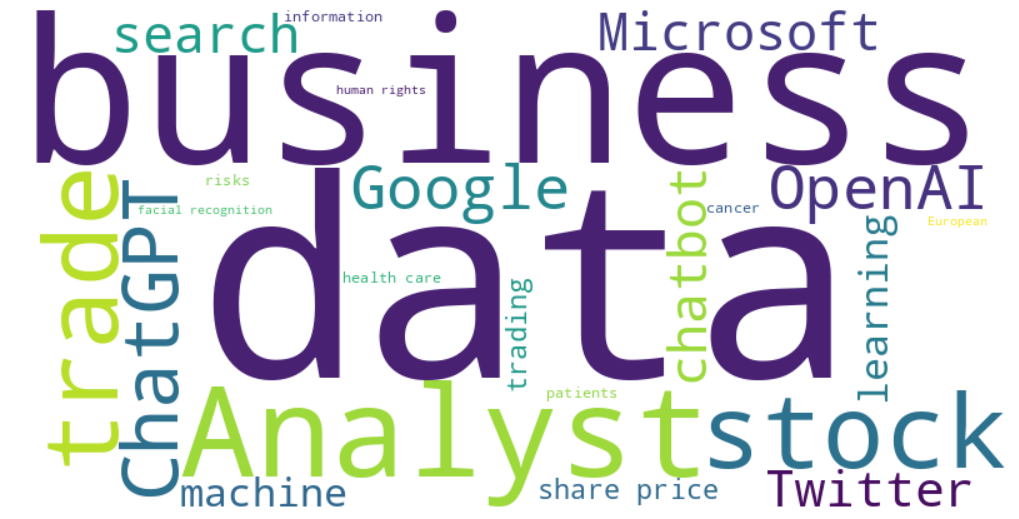

In [177]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define your words and their frequencies
words = {
    'data': 768, 'business': 768, 'Analyst': 768, 'stock': 768, 'trade': 768,
    'ChatGPT': 394, 'Google': 394, 'OpenAI': 394, 'Microsoft': 394, 'search': 394, 'chatbot': 394, 'Twitter': 394,
    'learning': 245, 'machine': 245, 'share price': 245, 'trading': 245,
    'health care': 20, 'risks': 20, 'patients': 20, 'information': 20, 'cancer': 20,
    'human rights': 13, 'facial recognition': 13, 'European': 13
}

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud
wordcloud.generate_from_frequencies(words)

# Display the generated image
plt.figure(figsize=(10,5), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()
